In [3]:
!pip install yfinance

You should consider upgrading via the 'C:\Users\Enrico\PycharmProjects\bfh-ai-1\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import os.path
from functools import reduce


import bs4 as bs
import requests
import yfinance as yf
import datetime
import time
import os
import pandas_datareader as web
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt


In [5]:
class MyDataset():

    def __init__(self):
        self.url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        self.stocks_fname = "sp500_closefull.csv"
        self.start = datetime.datetime(2010, 1, 1)
        self.stop = datetime.datetime.now()
        self.Ntest = 1000
        self.now = time.time()

    def get_train_test(self) -> pd.DataFrame:

        start = self.start  
        end = self.stop 


        if not os.path.isfile(self.stocks_fname):
          resp = requests.get(self.url)
          soup = bs.BeautifulSoup(resp.text, 'lxml')
          table = soup.find('table', {'class': 'wikitable sortable'})
          tickers = []

          for row in table.findAll('tr')[1:]:
              ticker = row.findAll('td')[0].text
              tickers.append(ticker)

          tickers = [s.replace('\n', '') for s in tickers]
          data = yf.download(tickers, start=start, end=end)
          data['Adj Close'].to_csv(self.stocks_fname)

        df0 = pd.read_csv(self.stocks_fname, index_col=0, parse_dates=True)

        df_spy = yf.download("SPY", start=start, end=end)

        #df_spy = web.DataReader("SPY", "yahoo", start=start, end=end)
        df_spy = df_spy.loc[:, ['Adj Close']]
        df_spy.columns = ['SPY']
        df0 = pd.concat([df0, df_spy], axis=1)


        #df0.dropna(axis=1, how='all', inplace=True)
        df0.dropna(axis=0, how='all', inplace=True)
        print("Dropping columns due to nans > 50%:", df0.loc[:, list((100 * (df0.isnull().sum() / len(df0.index)) > 50))].columns)
        df0 = df0.drop(df0.loc[:, list((100 * (df0.isnull().sum() / len(df0.index)) > 50))].columns, 1)
        df0 = df0.ffill().bfill()

        print("Any columns still contain nans:", df0.isnull().values.any())

        df_returns = pd.DataFrame()
        for name in df0.columns:
          df_returns[name] = np.log(df0[name]).diff()

        #df_returns['SPY_PRICE'] = df0['SPY']
        #df_returns[self.config.stocks_adj_close_names] = df0[self.config.stocks]
        # split into train and test
        df_returns.dropna(axis=0, how='any', inplace=True)


        train_data = df_returns.iloc[:-self.Ntest]
        test_data = df_returns.iloc[-self.Ntest:]


        return train_data, test_data

In [6]:
dataset = MyDataset()
train, test = dataset.get_train_test()

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: None
[*********************100%***********************]  1 of 1 completed
Dropping columns due to nans > 50%: Index(['BF.B', 'BRK.B', 'CARR', 'CDAY', 'CTVA', 'DOW', 'FOX', 'FOXA', 'FTV',
       'HWM', 'IR', 'LW', 'MRNA', 'OGN', 'OTIS', 'UA'],
      dtype='object')
Any columns still contain nans: False


In [7]:
train.head(5)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.007375,-0.014569,-0.002474,0.015445,0.0,0.021253,0.001145,0.008668,0.013641,0.008393,...,0.012689,0.013980,0.004539,0.0,0.003426,0.015277,0.011224,0.038231,0.0,0.016817
2010-01-05,-0.010922,0.107246,-0.005961,0.001727,0.0,-0.007160,-0.024321,-0.008112,0.006162,0.016313,...,-0.012689,0.003897,-0.011959,0.0,-0.003426,0.031165,-0.001745,0.034652,0.0,0.002644
2010-01-06,-0.003559,-0.042314,0.008682,-0.016034,0.0,-0.009501,-0.015358,0.005539,0.010574,-0.002124,...,-0.006807,0.008606,0.006566,0.0,-0.007174,-0.000323,-0.007717,0.083381,0.0,0.000704
2010-01-07,-0.001297,0.029043,-0.000247,-0.001850,0.0,-0.016166,0.000000,0.008250,-0.000935,-0.019595,...,-0.010095,-0.003147,0.013005,0.0,-0.000288,0.022681,-0.025318,0.106160,0.0,0.004212
2010-01-08,-0.000325,-0.019269,0.003945,0.006626,0.0,0.010807,-0.020446,0.005099,-0.003986,-0.005436,...,0.014505,-0.004020,0.000000,0.0,0.000288,-0.021228,-0.003256,-0.016319,0.0,0.003322


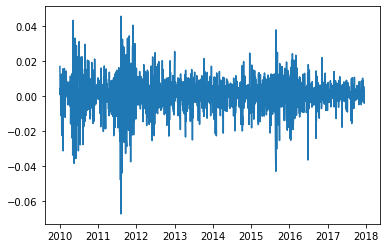

In [8]:
plt.plot(train.SPY)

In [9]:
train_labels = train.SPY.values
test_labes = train.SPY.values

In [10]:
train_labels.shape

(2003,)

In [11]:
train_features = train.iloc[:, :-1].values
test_features = train.iloc[:, :-1].values

In [12]:
train_features.shape

(2003, 489)

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

import torch.utils.data as data_utils

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

train_labels = torch.tensor(train_labels).float().to(device)
test_labels = torch.tensor(train_labels).float().to(device)

Using cpu device


In [14]:
train_features = torch.tensor(train_features).float().to(device)
test_features = torch.tensor(test_features).float().to(device)


In [15]:
training_data=data_utils.TensorDataset(train_features, train_labels)
test_data=data_utils.TensorDataset(test_features, test_labels)

In [16]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 489])
Shape of y:  torch.Size([64]) torch.float32


In [17]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        #self.linear_relu_stack = nn.Sequential(
        #    nn.Linear(28*28, 512), #Dense
        #    nn.ReLU(),
        #    nn.Linear(512, 512),
        #    nn.ReLU(),
        #    nn.Linear(512, 10)
        #)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(489, 36), #Dense
            nn.ReLU(),
            nn.Linear(36, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=489, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [18]:
loss_fn = nn.MSELoss(reduce="mean") # backward (gradienten werden gebildet partial derivatives der loss function und gradient)
#loss_fn = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # step (update) params = params - learningrate * grad

In [19]:
def train(dataloader, model, loss_fn, optimizer, epochs=20):
    size = len(dataloader.dataset)
    model.train()
    for e in range(epochs):
      print('Epoch: ', e)
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          #if X dann trainiere auf model 2
          loss = loss_fn(pred, y)

          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if batch % 10 == 0:
              loss, current = loss.item(), batch * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()   
    test_losses = []
    test_preds = []
    test_trues = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss = loss_fn(pred, y).item()
            test_preds.append(pred.numpy())
            test_trues.append(y.numpy())
            test_losses.append(test_loss)
            

    
    test_losses = np.array(test_losses).ravel()
    test_preds = np.array(test_preds).ravel()
    test_trues = np.array(test_trues).ravel()
    print(test_preds.shape)
    print(test_trues.shape)

    test_error = np.sum(np.abs(test_preds - test_trues))/ np.sum(np.abs(test_trues))

    print('Test Loss:', np.mean(test_losses))
    print('Test Error:', test_error)

In [21]:
#epochs = 5

#for t in range(epochs):
 #   print(f"Epoch {t+1}\n-------------------------------")
train(train_dataloader, model, loss_fn, optimizer)
test(test_dataloader, model, loss_fn)
print("Done!")

Epoch:  0
loss: 0.262104  [    0/ 2003]
loss: 0.089882  [  640/ 2003]
loss: 0.009204  [ 1280/ 2003]
loss: 0.000603  [ 1920/ 2003]
Epoch:  1
loss: 0.000316  [    0/ 2003]
loss: 0.000085  [  640/ 2003]
loss: 0.000062  [ 1280/ 2003]
loss: 0.000020  [ 1920/ 2003]
Epoch:  2
loss: 0.000083  [    0/ 2003]
loss: 0.000050  [  640/ 2003]
loss: 0.000050  [ 1280/ 2003]
loss: 0.000013  [ 1920/ 2003]
Epoch:  3
loss: 0.000079  [    0/ 2003]
loss: 0.000048  [  640/ 2003]
loss: 0.000047  [ 1280/ 2003]
loss: 0.000012  [ 1920/ 2003]
Epoch:  4
loss: 0.000079  [    0/ 2003]
loss: 0.000047  [  640/ 2003]
loss: 0.000047  [ 1280/ 2003]
loss: 0.000012  [ 1920/ 2003]
Epoch:  5
loss: 0.000079  [    0/ 2003]
loss: 0.000047  [  640/ 2003]
loss: 0.000046  [ 1280/ 2003]
loss: 0.000012  [ 1920/ 2003]
Epoch:  6
loss: 0.000079  [    0/ 2003]
loss: 0.000047  [  640/ 2003]
loss: 0.000046  [ 1280/ 2003]
loss: 0.000012  [ 1920/ 2003]
Epoch:  7
loss: 0.000079  [    0/ 2003]
loss: 0.000047  [  640/ 2003]
loss: 0.000046  [ 12

ValueError: operands could not be broadcast together with shapes (64,64) (19,19) 

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

# Hausaufgabe
erstellen von 2 Kategorien  
1 positiv steigend  => 1
2 negativ sinkend   => 0

In [ ]:
#classes = training_data.classes
classes = ["a", "b", "c"]

model.eval()
x, y = test_data[0][0], test_data[0][1]
print(f'Predicted: "{x}", Actual: "{y}"')
#with torch.no_grad():
#    pred = model(x)
#    predicted, actual = classes[pred[0].argmax(0)], classes[y]
#    print(f'Predicted: "{predicted}", Actual: "{actual}"')